### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [3]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [4]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. 

1. * For ubuntu just run: `sudo apt-get install graphviz` 
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [5]:
from mdp import has_graphviz
from IPython.display import display, clear_output, SVG, Image
print("Graphviz available:", has_graphviz)

Graphviz available: True


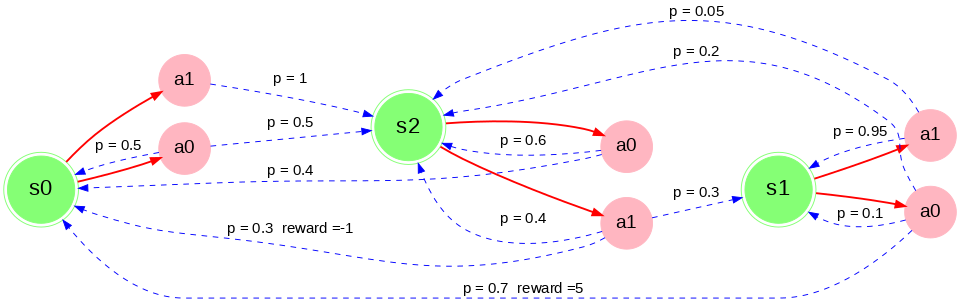

In [6]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    # display(plot_graph(mdp, graph_size='10,10'))

    graph = plot_graph(mdp)
    # graph.format = 'png'
    # graph.render(directory='./test', view=False)

    # print(type(graph.pipe(format='png')))
    # print(graph.pipe(format='png'))
    display(Image(graph.pipe(format='png')))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V_{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [7]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    # YOUR CODE
    sum = 0
    next_states = mdp.get_next_states(state, action)
    for next_state, prob in next_states.items():
        reward = mdp.get_reward(state, action, next_state)
        value = state_values[next_state]
        sum += prob * (reward + gamma * value)

    return sum

In [8]:
get_action_value(mdp, {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}, 's2', 'a1', 0.9)

0.6900000000000002

In [9]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [10]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    # YOUR CODE
    actions = mdp.get_possible_actions(state)
    values = [get_action_value(mdp, state_values, state, action, gamma) for action in actions]
    
    return max(values)

In [11]:
get_new_state_value(mdp, test_Vs, 's0', 0.9)

1.8

In [12]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

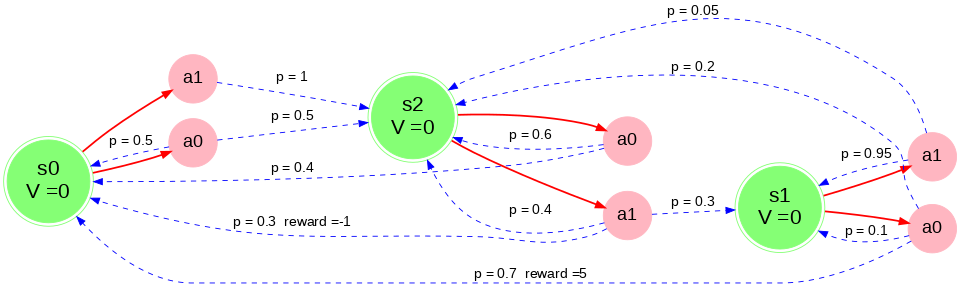

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [13]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001
# mdp.reset()

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    # display(plot_graph_with_state_values(mdp, state_values))
    graph = plot_graph_with_state_values(mdp, state_values)
    display(Image(graph.pipe(format='png')))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {# YOUR CODE
        state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()
    }

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

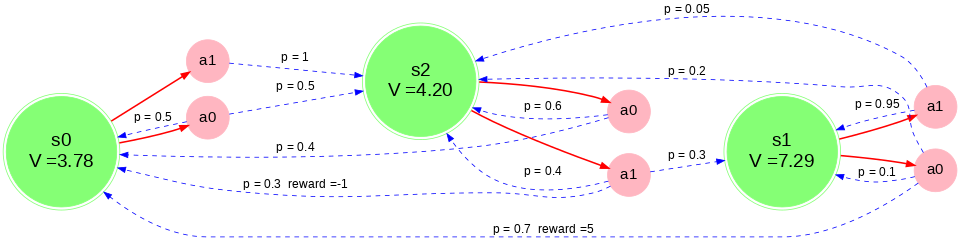

In [14]:
if has_graphviz:
    # display(plot_graph_with_state_values(mdp, state_values))
    graph = plot_graph_with_state_values(mdp, state_values)
    display(Image(graph.pipe(format='png')))

In [15]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [16]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    actions = mdp.get_possible_actions(state)
    values = [(get_action_value(mdp, state_values, state, action, gamma), action) for action in actions]

    return max(values)[1]

In [17]:
get_optimal_action(mdp, state_values, 's0', gamma)

'a1'

In [18]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

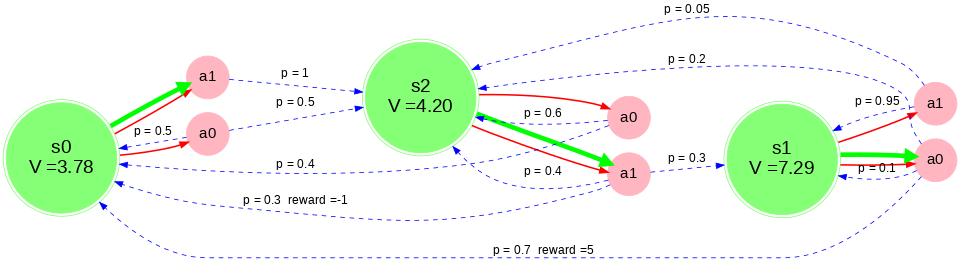

In [19]:
if has_graphviz:
    # display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))
    graph = plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value)
    display(Image(graph.pipe(format='png')))

In [20]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4596


### Frozen lake

In [21]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [22]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {# YOUR CODE
            state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()
        }

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        # print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
        #       (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [23]:
state_values = value_iteration(mdp)

In [24]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

right

S*FF
FHFH
FFFH
HFFG

right

SF*F
FHFH
FFFH
HFFG

down

SFFF
FH*H
FFFH
HFFG

down

SFFF
FHFH
FF*H
HFFG

down

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0


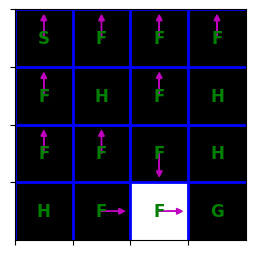

after iteration 1


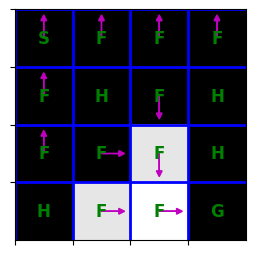

after iteration 2


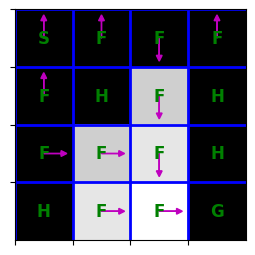

after iteration 3


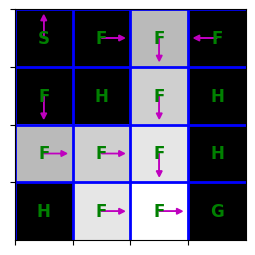

after iteration 4


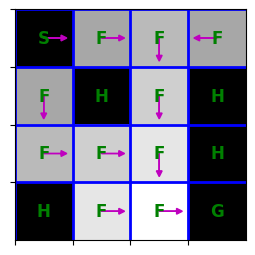

after iteration 5


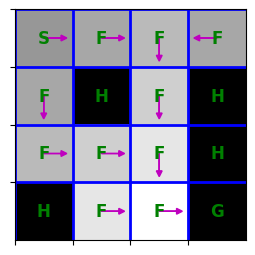

after iteration 6


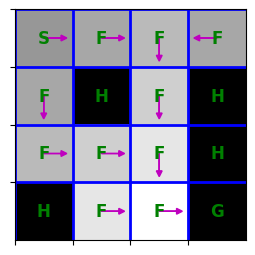

after iteration 7


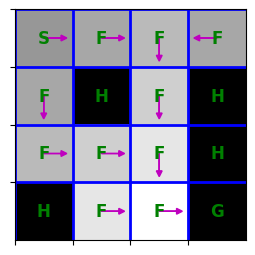

after iteration 8


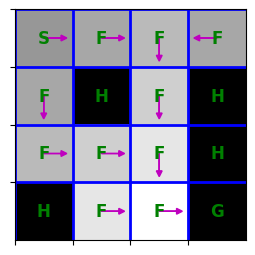

after iteration 9


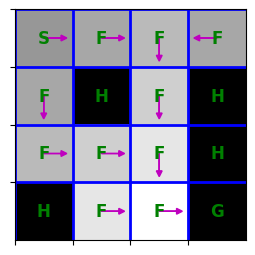

In [26]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29


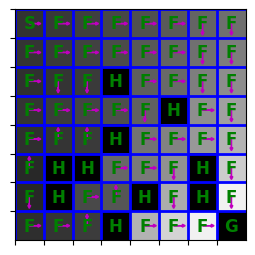

In [27]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [28]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

average reward:  1.0
Well done!


In [29]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

average reward:  0.88
Well done!


In [30]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

average reward:  0.649
Well done!


In [31]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

average reward:  0.755
Well done!


# HW Part 1: Value iteration convergence

### Find an MDP for which value iteration takes long to converge  (1 pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

In [32]:
transition_probs = {
   <YOUR CODE>
}
rewards = {
   <YOUR CODE>
}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Feel free to change the initial_state

In [ ]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

# please ignore iter 0 at each step

### Value iteration convervence proof (1 pts)
**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iterateion$

*<-- Your proof here -->*

Рассмотрим последовательность $(V_k)_{k\in\N}$, где $V_k = TV_{k-1}$. Известно, что $TV$ - contraction, значит справедливо заметить, что:
$$
||V_{k+1}-V_k||_\infty \le \gamma^k||V_1-V_0||_\infty
$$.
Исходя из этого справедливо, что $\forall m, n \in \N, m > n$:
$$
||V_m-V_n|| \le ||V_m-V_{m-1}||_\infty + ||V_{m-1}-V_{m-2}||_\infty + ... + ||V_{n+1}-V_n||_\infty \le \\
\le \gamma^{m-1}||V_1-V_0||_\infty + \gamma^{m-2}||V_1-V_0||_\infty + ... + \gamma^n||V_1-V_0||_\infty = \\
= \gamma^n||V_1-V_0||_\infty\sum_{k=0}^{m-n+1}\gamma^k \le \gamma^n||V_1-V_0||_\infty\sum_{k=0}^{+\infty}\gamma^k = \\
= \gamma^n||V_1-V_0||_\infty\frac{1}{1-\gamma}
$$
Докажем, что последовательность $(V_k)_{k\in\N}$ является последовательностью Коши. Выберем произвольно малый $\epsilon >0, \epsilon \in \R$. Для него можно найти такой наименьший из всех возможных N \in \N, что:
$$
\gamma^N \le \frac{\epsilon(1-\gamma)}{||V_1-V_0||_\infty}
$$
В таком случае, для $m, n > N$ верно, что:
$$
||V_m-V_n||_\infty \le \gamma^n||V_1-V_0||_\infty\frac{1}{1-\gamma} < \frac{\epsilon(1-\gamma)}{||V_1-V_0||_\infty}||V_1-V_0||_\infty\frac{1}{1-\gamma} = \epsilon
$$
Таким образом, $(V_k)_{k\in\N}$ является последовательностью Коши и имеет предел $V^* \in \R^{|S|}$:
$$
V^* = \lim_{k\to+\infty}V_k = \lim_{k\to+\infty}TV_{k-1}
$$
так как опреатор $TV$ является непрерывонй функцией, мы можем перенести предел внутрь оператора:
$$
V^* = \lim_{k\to+\infty}V_k = \lim_{k\to+\infty}TV_{k-1} = T\lim_{k\to+\infty}V_{k-1} = TV^*
$$
Таким образом, последовательность $(V_k)_{k\in\N}$ сходится к $V^*=TV^*$, Q.E.D. $\blacksquare$

### Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$    

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

*<-- Your proof here -->*


# HW Part 2: Policy iteration

## Policy iteration implementateion (3 pts)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [45]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

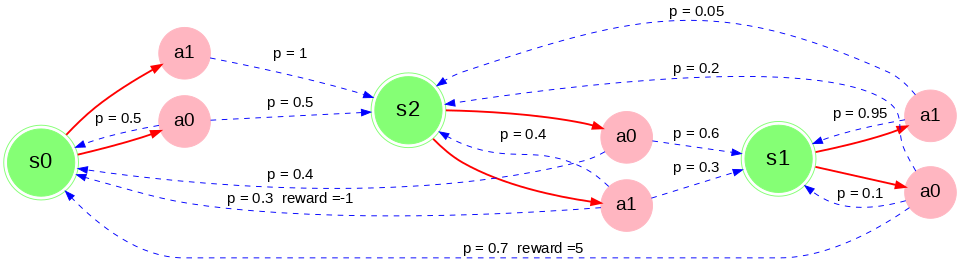

In [46]:
if has_graphviz:
    # display(plot_graph_with_state_values(mdp, state_values))
    graph = plot_graph(mdp)
    display(Image(graph.pipe(format='png')))

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [116]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    # YOUR CODE
    S = len(mdp.get_all_states())
    V_PI = np.zeros(shape=(S, 1))
    P_SS = np.zeros(shape=(S, S))
    R_SS = np.zeros(shape=(S, S))

    for i, begin in enumerate(mdp.get_all_states()):
        for j, end in enumerate(mdp.get_all_states()):
            if begin in policy:
                P_SS[i][j] = mdp.get_transition_prob(begin, policy[begin], end)
                R_SS[i][j] = mdp.get_reward(begin, policy[begin], end)
            else:
                P_SS[i] = np.zeros(shape=(S,))
                R_SS[i] = np.zeros(shape=(S,))
    R_SS = R_SS.T
    R = np.diagonal(P_SS @ R_SS).reshape((S, 1))
    # print(R)

    V_PI = np.linalg.inv(np.identity(S) - gamma * P_SS) @ R

    return {state: vpi[0] for state, vpi in zip(mdp.get_all_states(), V_PI)}

In [108]:
tmp = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]])
tmp[1] = np.zeros(shape=(3,))
tmp

array([[1, 2, 3],
       [0, 0, 0],
       [1, 2, 3]])

In [114]:
test_policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
print(test_policy)
compute_vpi(mdp, test_policy, gamma=0.9)

{'s0': 'a0', 's1': 'a0', 's2': 'a1'}


{'s0': 2.8399699474079685, 's1': 6.498873027798651, 's2': 3.4710743801652932}

In [115]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma=gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

{'s0': 0.0, 's1': 0.0, 's2': 0.0}


Once we've got new state values, it's time to update our policy.

In [129]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    # YOUR CODE
    ret = {}
    def action_value(mdp, vpi, gamma, state, action) -> float:
        next_states = mdp.get_next_states(state, action)
        action_state_values = [prob * (mdp.get_reward(state, action, next_state) + gamma * vpi[next_state]) for next_state, prob in next_states.items()]
        return sum(action_state_values)
    for state in mdp.get_all_states():
        action_values = [(action_value(mdp, vpi, gamma, state, action), action) for action in mdp.get_possible_actions(state)]
        # print(state)
        if len(action_values) == 0:
            # ret[state] = 0
            pass
        else:
            ret[state] = max(action_values)[1]
    return ret

In [51]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [130]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    # YOUR CODE: a whole lot of it
    vpi = None
    if policy is None:
        policy = {}
        for state in mdp.get_all_states():
            actions = mdp.get_possible_actions(state)
            if len(actions) != 0:
                policy[state] = np.random.choice(actions)
    # print(policy)

        # policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
    
    for i in range(num_iter):
        # print(i)
        new_vpi = compute_vpi(mdp, policy, gamma)
        if vpi is None:
            vpi = new_vpi
        elif max([new_value - old_value for new_value, old_value in zip(list(new_vpi.values()), list(vpi.values()))]) <= min_difference:
            return vpi, policy
        vpi = new_vpi
        new_policy = compute_new_policy(mdp, vpi, gamma)
        policy = new_policy

    return vpi, policy

__Your PI Results__

In [53]:
# <YOUR CODE: compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake>

In [138]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

value_vpi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5)
value_policy = compute_new_policy(mdp, value_vpi, gamma=0.9)

policy_vpi, policy_policy = policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5)

assert np.allclose(np.array(list(value_vpi.values())), np.array(list(policy_vpi.values())), atol=1e-3)
assert value_policy == policy_policy

In [139]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(map_name="4x4")

value_vpi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5)
value_policy = compute_new_policy(mdp, value_vpi, gamma=0.9)

policy_vpi, policy_policy = policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5)

assert np.allclose(np.array(list(value_vpi.values())), np.array(list(policy_vpi.values())), atol=1e-3)
assert value_policy == policy_policy

In [140]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(map_name="8x8")

value_vpi = value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5)
value_policy = compute_new_policy(mdp, value_vpi, gamma=0.9)

policy_vpi, policy_policy = policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5)

assert np.allclose(np.array(list(value_vpi.values())), np.array(list(policy_vpi.values())), atol=1e-3)
assert value_policy == policy_policy

## Policy iteration convergence (3 pts)

**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

We can define another Bellman operator:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

And rewrite policy iteration algorithm in operator form:


---

Initialize $\pi_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Solve $V_k = T_{\pi_k}V_k$   

&nbsp;&nbsp;&nbsp;&nbsp; Select $\pi_{k+1}$ s.t. $T_{\pi_{k+1}}V_k = TV_k$ 

**end for**

---

To prove convergence of the algorithm we need to prove two properties: contraction an monotonicity.

#### Monotonicity (0.5 pts)

For all $V, U$ if $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ then $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

*<-- Your proof here -->*

Перепишем оператор $T_\pi V(s)$ согласно определению математического ожидания:
$$
(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right] = \\
= \sum_{s' \in S} p(s', r | s, a = \pi(s)) \left[ r + \gamma * V(s') \right]
$$
Перепишем искомое неравенство, подставляя выведенное выше:
$$
(T_\pi V)(s) \quad?\quad (T_\pi U)(s) \Leftrightarrow \\ 
\Leftrightarrow \sum_{s' \in S} p(s', r | s, a = \pi(s)) \left[ r + \gamma * V(s') \right] \quad?\quad 
\sum_{s' \in S} p(s', r | s, a = \pi(s)) \left[ r + \gamma * U(s') \right] \Leftrightarrow \\
\Leftrightarrow \sum_{s' \in S} p(s', r | s, a = \pi(s)) \left[ V(s') \right] \quad?\quad 
\sum_{s' \in S} p(s', r | s, a = \pi(s)) \left[ U(s') \right]
$$

Вероятности $p(s', r | s, a = \pi(s))$ не зависят от $V, U$, при этом дано $V(s) \le U(s) \forall s \in \mathcal{S}$. Таким образом, обе части искомого неравенства можно представить как произведение векторов $PV \quad?\quad PU$, где $V$ покомпонентно меньше или равен $U$. Таким образом, левая часть неравенства меньше или равна правой, Q.E.D. $\blacksquare$

#### Contraction (1 pts)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

*<-- Your proof here -->*

Обозначим за $s^{max} \in \mathcal{S}$ такое состояние, для которого $V(s^{max}) - U(s^{max}) \ge V(s) - U(s), \forall s \in \mathcal{S}$.
Рассмотрим отдельно произвольную компоненту $s$ искомого вектора:
$$
TV(s)-TU(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right] - \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma U(s')\right] = \\
= \sum_{s'\in S} p(s',r | s,a=\pi(s))\left[r + \gamma V(s')\right] - \sum_{s'\in S} p(s',r | s,a=\pi(s))\left[r + \gamma U(s')\right] = \\
= \gamma \sum_{s'\in S} p(s',r | s,a=\pi(s))\left[ V(s')-U(s') \right] \le \\
\le \gamma (V(s^{max})-U(s^{max})) \le \\
\le \gamma (|V(s^{max})-U(s^{max})|) \le \\
\le \gamma ||V-U||_\infty
$$
Т.к. выражение выше верно $\forall s \in \mathcal{S}$, оно верно в том числе для $s^* \in \mathcal{S}$ такого, что
$$|TV(s^*)-TU(s^*)| \ge |TV(s)-TU(s)|, \forall s \in \mathcal{S}$$
Таким образом, 
$$
||TV-TU||_\infty = TV(s^*)-TU(s^*) \le \gamma ||V-U||_\infty, \quad Q.E.D. \blacksquare
$$

#### Convergence (1.5 pts)

Prove that there exists iteration $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$

*<-- Your proof here -->*

Пусть алгоритм Policy Iteration был запущен на $K$ итераций. Выделим последовательности $(V_k)_{1\le k\le K}, (\pi_k)_{1\le k\le K}$ как полученные алгоритмом на $k$-ом шаге векторы values состояний и вычисленная по этим values политика. Требуется доказать, что, $\pi_{k_0} = \pi_{k_0+1} = ... = \pi_K$ для какого-то $k_0$.

Для начала докажем, что $\pi_{k_0} = \pi_{k_0+1}$ для какого-то $k_0$. $\pi_{k_0+1}$ вычисляется на основании $V_{k_0+1}$, которая вычисляется на основании $\pi_{k_0}$, которая вычисляется на основании $V_{k_0}$. Предположим, что $\pi_{k_0}$ такова, что $V_{k_0+1} = V_{k_0}$. Тогда, соласно формуле Policy Improvement, $\pi_{k_0} = \pi_{k_0+1} = ... = \pi_K$ - это как раз искомый итоговый результат. Однако, условие $V_{k_0+1} = V_{k_0}$ является слишком жёстким. Рассмотрим внимательнее формулу Policy Improvement, для удобства не в операторном виде:
$$
\pi(s) \leftarrow \argmax_a \sum_{s', r} p(s', r | s, a) \left[ r + \gamma * V(s') \right] = \argmax_a q(s, a)
$$
Пусть верно, что $||q_{k_0}(s, a)||_\infty = d$, то есть наименьшая абсолютная разница значений пар компонент вектора размерности $a$, из которого выбирается действие политики на шаге Policy Improvement, равно $d$. В таком случае можно гарантировать, что $\pi_{k_0} = \pi_{k_0+1}$, если векторы $q_{k_0}(s, a)$ и $q_{k_0+1}(s, a)$ покомпонентно различаются менее, чем на $\frac{d}{2}$, т.к. в таком случае упорядоченность компонент по возрастанию/убыванию не изменится, и, как следствие, не изменится результат $\argmax_a q(s, a)$. При этом $p, r, \gamma$ являются параметрами MDP и не изменяются между итерациями. Таким образом, изменение $q(s, a)$ между итерациями вызвано исключительно изменением $V(s)$, и "достаточно малые" изменения $V(s)$ соответствуют "достаточно малым" изменениям $q(s, a)$. Эти условия выполнялись бы, если бы, например, последовательность $(V_k)$ была бы последовательностью Коши. Более того, в таком случае выполнялось бы общее условие $\pi_{k_0} = \pi_{k_0+1} = ... = \pi_K$ для какого-то $k_0$, и исходная теорема была бы доказана.

Последовательность $(V_k)$  получена последовательным применением оператора $TV$, который является непрерывным и является contraction. Таким образом, произведённая им последовательность является последовательностью Коши, и доказательство проходит аналогично доказательству для оператора Value Iteration, приведённому выше. Соответственно, эта последовательность имеет предел $V^* \in \R^{|S|}$, и, начиная с какого-то $k_0$, $||V_{k_0+j}-V_{k_0}||_\infty$ становится "достаточно мала" для того, чтобы $||q_{k_0+j}(s, a)-q_{k_0}(s, a)||_\infty$ стала "достаточно мала" для того, чтобы упорядоченность компонент $q_{k_0+j}(s, a)$ и $q_{k_0}(s, a)$ стала одинаковой, и $\argmax_a q_{k_0+j}(s, a) = \argmax_a q_{k_0}(s, a)$, и $\pi_{k_0+j} = \pi_{k_0}$, Q.E.D. $\blacksquare$